# Data processing
Seidelin trap. Seidelin 2006 prl, DOI: 10.1103/PhysRevLett.96.253003

In [1]:
!pwd
!which python

import sys
import logging, os
import numpy as np
import matplotlib.pyplot as plt
# from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list.
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list.

/home/wwc/bem_log/bem/examples/SeidelinTrap
/home/wwc/anaconda3/envs/ele35/bin/python


In [2]:
# name of vtk files (usually the same as stl file)
prefix = "SE_20180727_0d1_0d1_8"    # "SE_20180727_0d1_0d1_8"
suffix = ""

### Read data from VTK files saved by `bem` package

In [3]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 DC6 RF".split():
    e = GridElectrode.from_vtk("%s%s_"%(prefix,suffix)+name+".vtk",maxderiv=4)    # classmethod
    e.name = name
    s.append(e)    # class System(list), System inherits list method "append".
# System() class has a "__getitem__() method", so instance s is subscriptable (can use []).
print(s["RF"],s["RF"].rf)

<electrode.electrode.GridElectrode object at 0x7f836aeb2f10> 0.0


### Define ion physical parameters and set electrode voltages

In [4]:
import scipy.constants as ct
l = 40e-6 # length scale
u = 103.25 # peak rf voltage
o = 87e6*2*np.pi # rf frequency
m = 24.3*ct.atomic_mass # ion (Mg+) mass
q = 1*ct.elementary_charge # ion charge
# coefficient of pseudo-potential. See blakestad2010 Eq.(5.2). Run rf_scale() before other calculations.
rf_scale = s.rf_scale(m,q,l,o)

# Set voltages (from Seidelin 2006 prl DOI: 10.1103/PhysRevLett.96.253003)
V5 = 5.0
DCvol = {"DC1":0.320*V5,"DC2":0.718*V5,"DC3":0.738*V5,"DC4":-0.898*V5,"DC5":V5,"DC6":0.0*V5}
for edc in DCvol:
    s[edc].dc = DCvol[edc]
    print(edc,s[edc].dc,"V")
s["RF"].rf = u   # s["RF"].rf = u*np.sqrt(q/m)/(2*l*o)
print("RF",s["RF"].rf,"V")

DC1 1.6 V
DC5 5.0 V
DC3 3.69 V
DC2 3.59 V
DC4 -4.49 V
DC6 0.0 V
RF 103.25 V


### Trap parameters

In [6]:
# Search minimum and print trap parameters such as secular frequency
xi = (0.0, 1.0, 1.0)    # (-0.4, 1.1, 1.0)
# Use 'Nelder-Mead'/'Powell'/'L-BFGS-B' method for minimum() if a precision loss error occurs.
# Default is 'Newton-CG'.
method = 'L-BFGS-B'    # Cautious! Different methods may lead to slight different minimums (error~grid step).
x0 = s.minimum(xi, method=method)
# x0 = np.array([0.0,1.013,0.86])
print("minimum x0:",x0)
print("minimum offset: {}\n".format(x0-xi))
for line in s.analyze_static(x0, m=m, q=q, l=l, o=o, min_off=False, min_method=method):
    print(line)

minimum x0: [-0.4015906   1.12187623  1.01909228]
minimum offset: [-0.4015906   0.12187623  0.01909228]

parameters:
 f=87 MHz, m=24.3 amu, q=1 qe, l=40 µm, scale=0.0456 V'/V_SI
corrdinates:
 analyze point: [-0.4015906   1.12187623  1.01909228]
               ([-16.06362386  44.87504939  40.76369105] µm)
 minimum is at offset: [  1.33104459e-05   4.58194210e-05   6.81896064e-05]
                      ([ 0.00053242  0.00183278  0.00272758] µm)
potential:
 dc electrical: 0.86 eV
 rf pseudo: 0.00031 eV
 saddle offset: [ -5.93152164e-04   6.74223065e-05   9.52384690e-05]
               ([-0.02372609  0.00269689  0.00380954] µm)
 saddle height: -6e-08 eV
force:
 dc electrical: [-0.00010085 -0.0016266  -0.04388134] eV/l
               ([   -2.52114385   -40.66489461 -1097.03353672] eV/m)
 rf pseudo: [  3.53576151e-05   1.40116167e-03   4.35458448e-02] eV/l
           ([  8.83940378e-01   3.50290417e+01   1.08864612e+03] eV/m)
modes:
 pp+dc normal curvatures: [ 0.11172756  3.40373919  4.14538

/home/wwc/anaconda3/envs/ele35/lib/python3.5/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


### Create plotting grid from VTK

In [7]:
from electrode import Grid
# find minimum x0 and saddle point xs
xi = (-0.4, 1.1, 1.0)
x0 = s.minimum(xi,method=method)
xs, xsp = s.saddle(x0+1e0*x0)    # 1e0*x0, intenally introduce an offset to search saddle around x0
print("Minimum x0/l: {}".format(x0))
print("Saddle xs/l: {}\nSaddle height: {}".format(xs,xsp))

# extract grid infomation from one GridElectrode instance (s[0])
step, shape = s[0].spacing, np.array(s[0].data[0].shape[:-1])
center = s[0].origin + (shape-1)*step/2
print("\ncenter/l: {}".format(center))
shape = np.array(shape)/2    # original shapes are too large, only interest in trap region
# locate center a little higher than x0 (or plot would include electrodes)
gridx = Grid(x0+np.array([0, 0, 0.2]), step, shape)
gridy = Grid(x0+np.array([0, 0, 0.2]), step, shape)

Minimum x0/l: [-0.40100633  1.12194255  1.01919062]
Saddle xs/l: [-0.42047383  1.46471022  1.83769215]
Saddle height: 1.0065888717879123

center/l: [ 0.  1.  1.]


/home/wwc/anaconda3/envs/ele35/lib/python3.5/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


max, min potential: 7.284496, 0.858222
max, min potential: 4.597797, 0.878112


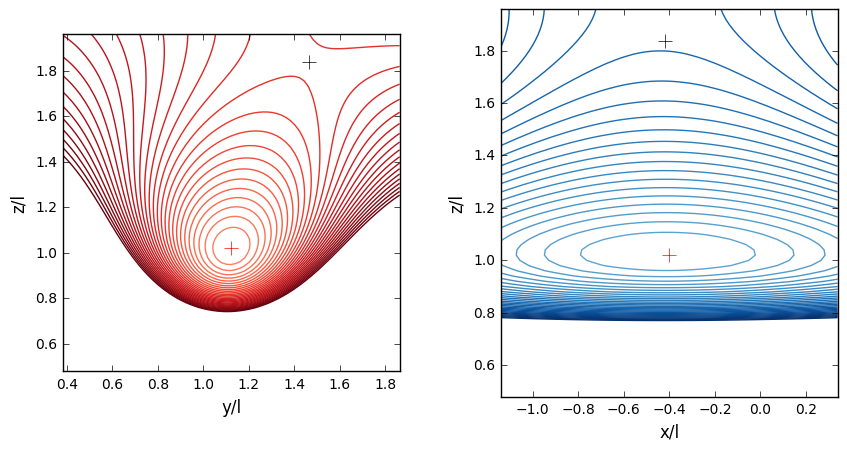

In [8]:
fig, ax = plt.subplots(1,2,gridspec_kw={'wspace':0.3},figsize=(10,5),dpi=100)
ax[0].set_aspect("equal")
# plot_contour() in System class.
# choose divide_max smaller than but close to max potential, or divide_max=-1
s.plot_contour(ax[0],grid=gridx,slc='x',slc_at=x0[0],divide_max=6,line_num=30,cmap=plt.cm.Reds)
s.plot_contour(ax[1],grid=gridy,slc='y',slc_at=x0[2],divide_max=4,line_num=30,cmap=plt.cm.Blues)
# plot minimum and saddle points with contour plot
ax[0].plot(x0[1],x0[2],'r+',markersize=10)    # red
ax[0].plot(xs[1],xs[2],'k+',markersize=10)    # black
ax[1].plot(x0[0],x0[2],'r+',markersize=10)
ax[1].plot(xs[0],xs[2],'k+',markersize=10)

In [9]:
# To understand the data structure of GridElectrode.data.
# print(e.origin, e.spacing)
# print(len(e.data),type(e.data))  # [pot_array,field_array,2nd_pot_array,3rd_pot_array], 0~3,4th derivative order.
# print(type(e.data[0]),type(e.data[1]))  # All list elements are ndarray.
# print(e.data[0].shape,e.data[1].shape)    # (nx,ny,nz,components)
# print(e.data[0])    # potential
# # [[[[p(x0,y0,z0)],
# #    [p(x0,y0,z1)],
# #    [p(x0,y0,z2)]],
# #    
# #   [[p(x0,y1,z0)],
# #    [p(x0,y1,z1)],
# #    [p(x0,y1,z2)]],     
# #
# #   ]]

Plot the horizontal logarithmic pseudopotential at the ion height and the logarithmic pseudopotential and the separatrix in the xz plane.

main saddle: [-0.56867905  0.51858507  7.9225702 ] 1.04660968052


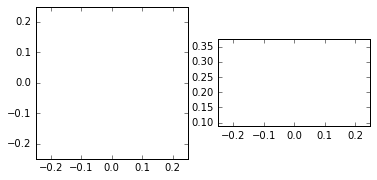

In [10]:
from electrode import shaped
n, h, d = 50, 1/8., 1/4.
xyz = np.mgrid[-d:d:1j*n, -d:d:1j*n, h:h+1]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect="equal"))
pot = shaped(s.potential)(xyz)
v = np.arange(-15, 3)
x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
ax[0].contour(x, y, np.log2(p), v, cmap=plt.cm.hot)

(xs1, ps1), (xs0, ps0) = s.saddle(x0+1e-2), s.saddle([0, 0, .8])
print("main saddle:", xs0, ps0)
xyz = np.mgrid[-d:d:1j*n, 0:1, .7*h:3*h:1j*n]
pot = shaped(s.potential)(xyz)
x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
ax[1].contour(x, z, np.log2(p), v, cmap=plt.cm.hot)
ax[1].contour(x, z, np.log2(p), np.log2((ps1, ps0)), color="black")